In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import os
import networkx as nx

In [2]:
import pandas as pd

#Read discussion network data from a csv file
dnet_df = pd.read_csv('discussion_network_with_affiliations.csv')
#Display the first 5 rows of the dataframe
dnet_df.head()

,consumer,contributor,consumption,contributor_affiliation,consumer_affiliation
0,mitsudome-r,maxime-clem,1,tier4,tier4
1,mitsudome-r,xczhanjun,1,baidu usa,tier4
2,mitsudome-r,xmfcx,7,leodrive,tier4
3,mitsudome-r,meliketanrikulu,1,leodrive,tier4
4,mitsudome-r,kminoda,1,tier4,tier4


In [3]:
dnet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   consumer                 1087 non-null   object
 1   contributor              1087 non-null   object
 2   consumption              1087 non-null   int64 
 3   contributor_affiliation  981 non-null    object
 4   consumer_affiliation     707 non-null    object
dtypes: int64(1), object(4)
memory usage: 42.6+ KB


In [4]:
#Aggregate the data by contributor_affiliation and consumer_affiliation, sum teh values of consumption, keep the contributor_affiliation and consumer_affiliation columns
dnet_grouped = dnet_df.groupby(['consumer', 'contributor'])['consumption'].sum().reset_index()
#Display the first 5 rows of the dataframe
dnet_grouped.head()

,consumer,contributor,consumption
0,08beeqtufail-sudo,TakaHoribe,1
1,AElkenawy,Levinskis,1
2,AElkenawy,wbq0206,1
3,AElkenawy,zulfaqar-azmi-t4,1
4,AhmadAmine998,TakaHoribe,1


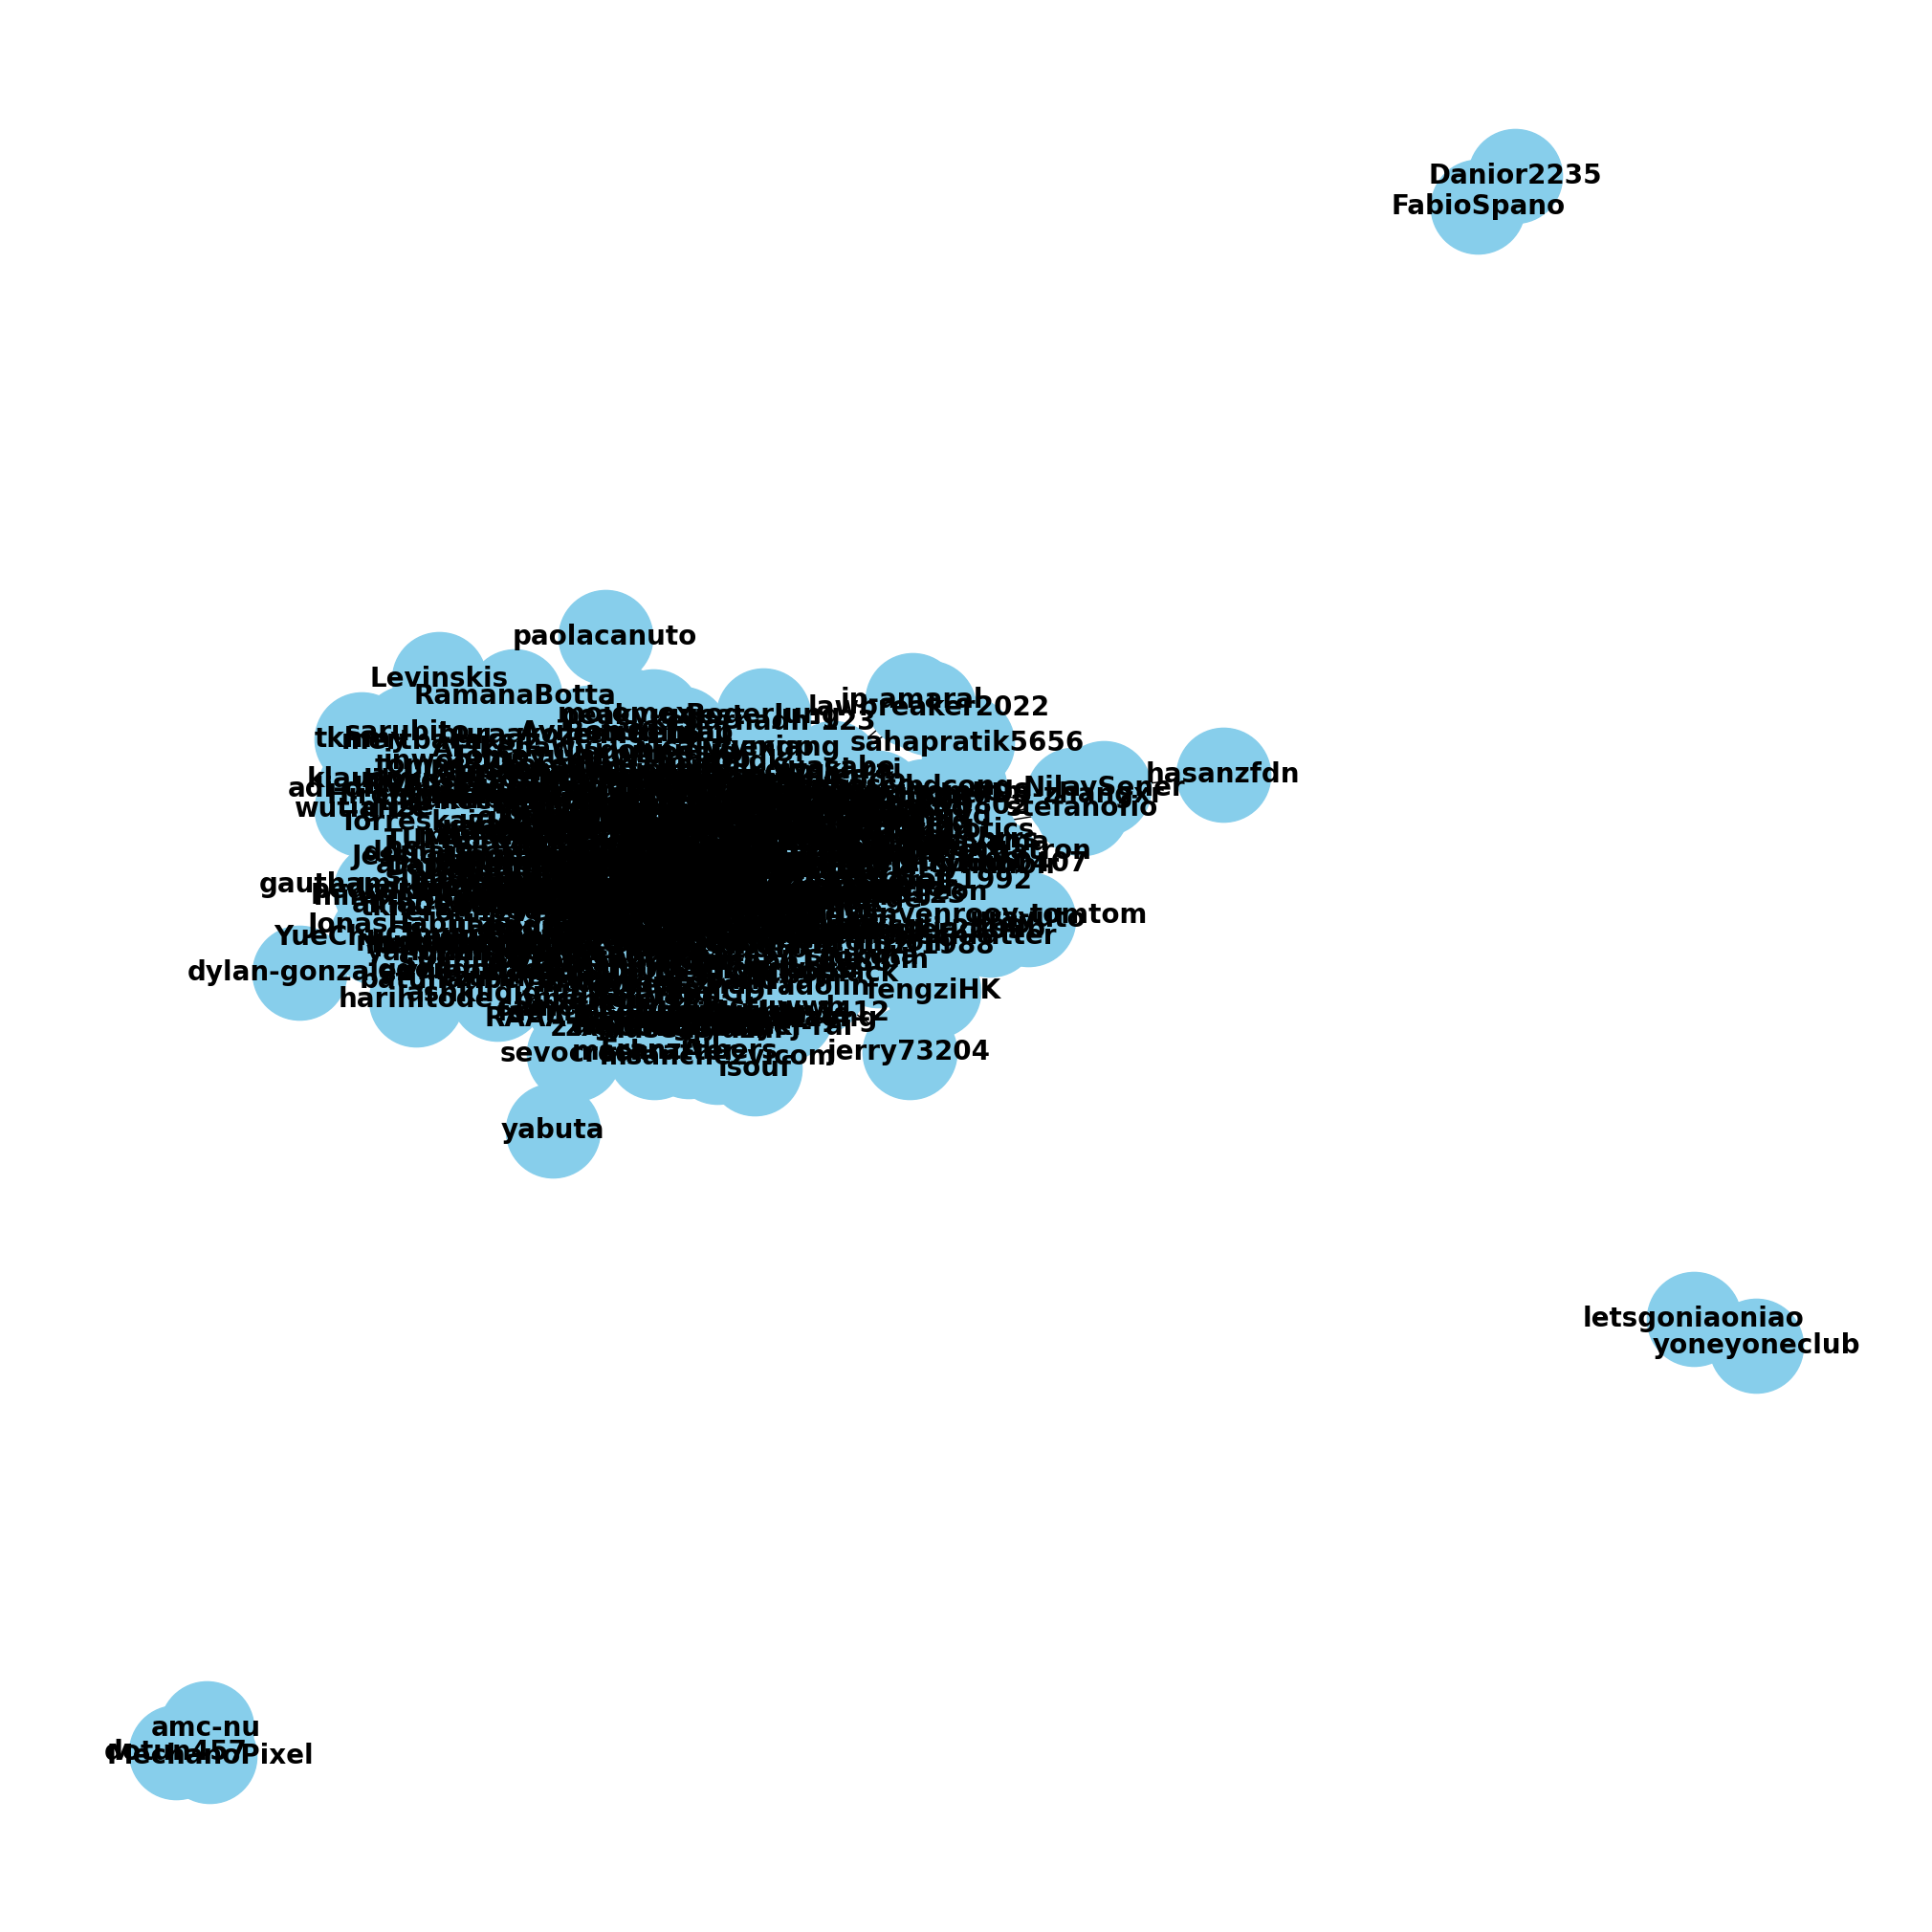

In [5]:
#Draw a network among the affiliations based on the consumption of the discussions
G = nx.from_pandas_edgelist(dnet_grouped, 'consumer', 'contributor', 'consumption')
plt.figure(figsize=(20, 20))
nx.draw(G, with_labels=True, node_size=5000, node_color='skyblue', font_size=20, font_weight='bold')
plt.show()

In [6]:
!pip install pyvis

In [7]:
discussion_df = pd.read_csv('updated_user_details.csv')
discussion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        567 non-null    int64  
 1   user_id                           567 non-null    object 
 2   skills                            147 non-null    object 
 3   email                             324 non-null    object 
 4   location                          133 non-null    object 
 5   affiliation                       368 non-null    object 
 6   name                              400 non-null    object 
 7   discussion_thread                 352 non-null    float64
 8   discussion_thread_internal        352 non-null    float64
 9   discussion_thread_external        352 non-null    float64
 10  discussion_contribution           352 non-null    float64
 11  discussion_contribution_internal  352 non-null    float64
 12  discussi

In [8]:
# Specify columns to remove
columns_to_remove = ['Unnamed: 0']

# Drop the specified columns
discussion_df = discussion_df.drop(columns=columns_to_remove)

discussion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   user_id                           567 non-null    object 
 1   skills                            147 non-null    object 
 2   email                             324 non-null    object 
 3   location                          133 non-null    object 
 4   affiliation                       368 non-null    object 
 5   name                              400 non-null    object 
 6   discussion_thread                 352 non-null    float64
 7   discussion_thread_internal        352 non-null    float64
 8   discussion_thread_external        352 non-null    float64
 9   discussion_contribution           352 non-null    float64
 10  discussion_contribution_internal  352 non-null    float64
 11  discussion_contribution_external  352 non-null    float64
 12  discussi

In [9]:
import pandas as pd
from pyvis.network import Network

# Read discussion network data from a csv file
dnet_df = pd.read_csv('discussion_network_with_affiliations.csv')
# discussion_df = pd.read_csv('discussion_data.csv')

# Calculate the standard deviation and average of 'issues_collaboration_index'
std_disc_index = discussion_df['discussions_collaboration_index'].std()
avg_disc_index = discussion_df['discussions_collaboration_index'].mean()

# Calculate the range for coloring nodes
range_low = avg_disc_index - std_disc_index
range_high = avg_disc_index + std_disc_index

# Aggregate the data by contributor and consumer, sum the values of consumption
dnet_grouped = dnet_df.groupby(['consumer', 'contributor'])['consumption'].sum().reset_index()

# Sort the DataFrame by consumption (highest to lowest)
dnet_grouped_sorted = dnet_grouped.sort_values(by='consumption', ascending=False)

# Create a pyvis network with a white background
net = Network(height="750px", width="100%", bgcolor="white", font_color="black", directed=True)

# Create an empty dictionary to store added nodes
added_nodes = {}

# Define the minimum weight threshold for displaying edges
min_weight_threshold = 0

# Create a dictionary to store the count of rows for each pair of interchangeable affiliations
interchangeable_counts = {}

# Count the occurrences of each pair of interchangeable affiliations
for _, row in dnet_grouped.iterrows():
    contributor = row['contributor']
    consumer = row['consumer']
    if contributor > consumer:
        pair = (consumer, contributor)
    else:
        pair = (contributor, consumer)
    interchangeable_counts[pair] = interchangeable_counts.get(pair, 0) + 1

# Add nodes for each unique affiliation (handling potential missing values)
for affiliation in pd.concat([dnet_grouped_sorted['contributor'], dnet_grouped_sorted['consumer']]).unique():
    if not pd.isna(affiliation):
        # Find the corresponding collaboration index and assign a color
        if affiliation in discussion_df['user_id'].values:
            collaboration_index = discussion_df.loc[discussion_df['user_id'] == affiliation, 'issues_collaboration_index'].values[0]
            if collaboration_index < range_low:
                color = 'red'
            elif range_low <= collaboration_index <= range_high:
                color = 'blue'
            else:
                color = 'green'
            # Set node size based on the collaboration index
            size = collaboration_index * 10  # Adjust the multiplier as needed
        else:
            # Skip nodes not found in discussion_df to ensure no sky blue color is assigned
            continue

        net.add_node(affiliation, label=affiliation, size=size, color=color)
        added_nodes[affiliation] = True

# Add edges to the network with the aggregated consumption values and adjusted width
for index, row in dnet_grouped_sorted.iterrows():
    contributor = row['contributor']
    consumer = row['consumer']
    consumption = row['consumption']

    # Add edge only if both nodes exist in the network and weight meets threshold
    if (contributor in added_nodes) and (consumer in added_nodes) and consumption >= min_weight_threshold:
        # Ensure we add edges in both directions for interchangeable affiliations
        edge_key = (contributor, consumer)
        if interchangeable_counts.get(edge_key, 0) > 1:
            # Add edge between affiliations in both directions if not added already
            if edge_key not in added_nodes:
                net.add_edge(contributor, consumer, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[edge_key] = True
            if (consumer, contributor) not in added_nodes:
                net.add_edge(consumer, contributor, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[(consumer, contributor)] = True
        else:
            # Add only one edge if the affiliations are not interchangeable or there's only one occurrence
            if edge_key not in added_nodes:
                net.add_edge(contributor, consumer, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[edge_key] = True

# Set the layout algorithm to force-directed
net.barnes_hut(gravity=-8000, central_gravity=0.3, spring_length=200)

# Save the network to an HTML file with added label
net.show_buttons(filter_=['physics'])

# Generate the HTML file content without title
html_content = net.generate_html()

# Add the label and legend to the body of the HTML content
html_content = html_content.replace(
    "<body>",
    "<body><h1 style='text-align:center;'>Discussions User Centric with Threshold Value '0'</h1>"
    "<ul style='text-align:center; list-style-type:none;'>"
    "<li style='color:red;'>Red: Below Range Low</li>"
    "<li style='color:green;'>Green: Above Range High</li>"
    "<li style='color:blue;'>Blue: Within Range</li>"
    "</ul>"
)

# Save the HTML file
with open("discussion_user_method_2_zero.html", "w") as f:
    f.write(html_content)

In [10]:
import pandas as pd
from pyvis.network import Network

# Read discussion network data from a csv file
dnet_df = pd.read_csv('discussion_network_with_affiliations.csv')
# discussion_df = pd.read_csv('discussion_data.csv')

# Calculate the standard deviation and average of 'issues_collaboration_index'
std_disc_index = discussion_df['discussions_collaboration_index'].std()
avg_disc_index = discussion_df['discussions_collaboration_index'].mean()

# Calculate the range for coloring nodes
range_low = avg_disc_index - std_disc_index
range_high = avg_disc_index + std_disc_index

# Aggregate the data by contributor and consumer, sum the values of consumption
dnet_grouped = dnet_df.groupby(['consumer', 'contributor'])['consumption'].sum().reset_index()

# Sort the DataFrame by consumption (highest to lowest)
dnet_grouped_sorted = dnet_grouped.sort_values(by='consumption', ascending=False)

# Create a pyvis network with a white background
net = Network(height="750px", width="100%", bgcolor="white", font_color="black", directed=True)

# Create an empty dictionary to store added nodes
added_nodes = {}

# Define the minimum weight threshold for displaying edges
min_weight_threshold = 3

# Create a dictionary to store the count of rows for each pair of interchangeable affiliations
interchangeable_counts = {}

# Count the occurrences of each pair of interchangeable affiliations
for _, row in dnet_grouped.iterrows():
    contributor = row['contributor']
    consumer = row['consumer']
    if contributor > consumer:
        pair = (consumer, contributor)
    else:
        pair = (contributor, consumer)
    interchangeable_counts[pair] = interchangeable_counts.get(pair, 0) + 1

# Add nodes for each unique affiliation (handling potential missing values)
for affiliation in pd.concat([dnet_grouped_sorted['contributor'], dnet_grouped_sorted['consumer']]).unique():
    if not pd.isna(affiliation):
        # Find the corresponding collaboration index and assign a color
        if affiliation in discussion_df['user_id'].values:
            collaboration_index = discussion_df.loc[discussion_df['user_id'] == affiliation, 'issues_collaboration_index'].values[0]
            if collaboration_index < range_low:
                color = 'red'
            elif range_low <= collaboration_index <= range_high:
                color = 'blue'
            else:
                color = 'green'
            # Set node size based on the collaboration index
            size = collaboration_index * 10  # Adjust the multiplier as needed
        else:
            # Skip nodes not found in discussion_df to ensure no sky blue color is assigned
            continue

        net.add_node(affiliation, label=affiliation, size=size, color=color)
        added_nodes[affiliation] = True

# Add edges to the network with the aggregated consumption values and adjusted width
for index, row in dnet_grouped_sorted.iterrows():
    contributor = row['contributor']
    consumer = row['consumer']
    consumption = row['consumption']

    # Add edge only if both nodes exist in the network and weight meets threshold
    if (contributor in added_nodes) and (consumer in added_nodes) and consumption >= min_weight_threshold:
        # Ensure we add edges in both directions for interchangeable affiliations
        edge_key = (contributor, consumer)
        if interchangeable_counts.get(edge_key, 0) > 1:
            # Add edge between affiliations in both directions if not added already
            if edge_key not in added_nodes:
                net.add_edge(contributor, consumer, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[edge_key] = True
            if (consumer, contributor) not in added_nodes:
                net.add_edge(consumer, contributor, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[(consumer, contributor)] = True
        else:
            # Add only one edge if the affiliations are not interchangeable or there's only one occurrence
            if edge_key not in added_nodes:
                net.add_edge(contributor, consumer, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[edge_key] = True

# Set the layout algorithm to force-directed
net.barnes_hut(gravity=-8000, central_gravity=0.3, spring_length=200)

# Save the network to an HTML file with added label
net.show_buttons(filter_=['physics'])

# Generate the HTML file content without title
html_content = net.generate_html()

# Add the label and legend to the body of the HTML content
html_content = html_content.replace(
    "<body>",
    "<body><h1 style='text-align:center;'>Discussions User Centric with Threshold Value '3'</h1>"
    "<ul style='text-align:center; list-style-type:none;'>"
    "<li style='color:red;'>Red: Below Range Low</li>"
    "<li style='color:green;'>Green: Above Range High</li>"
    "<li style='color:blue;'>Blue: Within Range</li>"
    "</ul>"
)

# Save the HTML file
with open("discussion_user_method_2_three.html", "w") as f:
    f.write(html_content)